1.

Below is a high‐level schematic of a vanilla GAN and an explanation of the adversarial training process:

```
      ┌───────────┐                       ┌──────────────────┐
      │ Noise z ~ │                       │ Real data x ~    │
      │   p(z)     │                       │   p_data(x)      │
      └─────┬─────┘                       └─────┬───────────┘
            │                                      │
            ▼                                      │
      ┌───────────┐      Generated sample x̂        │
      │ Generator │ ───────────────────────────────►│
      │   G(z)    │                                ▼ │
      └─────┬─────┘                       ┌──────────────────┐
            │                            │ Discriminator D   │
            │                            │   outputs D(·)    │
            │                            └──────┬───────────┘
            │ Real? vs Fake?                   │
            │                                   │
            │◄──────────────────────────────────┘
```

---

## 1. Adversarial Objectives

* **Discriminator, D**

  * **Goal:** Maximize its ability to distinguish real samples from generated ones.
  * **Loss (to maximize):**

𝐿
𝐷
=
𝐸
𝑥
∼
𝑝
data
[
log
⁡
𝐷
(
𝑥
)
]
+
𝐸
𝑧
∼
𝑝
(
𝑧
)
[
log
⁡
(
1
−
𝐷
(
𝐺
(
𝑧
)
)
)
]
.

  * **Interpretation:**

    * Push D(x) → 1 for real x
    * Push D(G(z)) → 0 for fake x̂

* **Generator, G**

  * **Goal:** Produce samples G(z) that fool D into thinking they are real.
  * **Common Loss (to minimize):**

    $$
      \mathcal{L}_G = \mathbb{E}_{z\sim p(z)}\bigl[\!-\log D(G(z))\bigr],
    $$

    which equivalently maximizes D(G(z)).
  * **Interpretation:**

    * Encourage D(G(z)) → 1, i.e. generated samples look “real.”

Together, this forms the minimax game

$$
  \min_G \max_D \; V(D,G)
  = \mathbb{E}_{x}\bigl[\log D(x)\bigr]
    + \mathbb{E}_{z}\bigl[\log(1 - D(G(z)))\bigr].
$$

---

## 2. Training Dynamics

1. **Discriminator step:**

   * Sample a minibatch of real data $\{x^{(i)}\}$ and noise $\{z^{(i)}\}$.
   * Compute gradient of $\mathcal{L}_D$, update D to better separate real vs. fake.
2. **Generator step:**

   * Sample a minibatch of noise $\{z^{(i)}\}$.
   * Compute gradient of $\mathcal{L}_G$, update G to produce more realistic outputs.
3. **Repeat** until convergence (ideally $D(x)\approx D(G(z))\approx 0.5$).

---

### Why It Works

* The **discriminator** provides a learned loss function to the generator.
* The **generator** uses gradients from D to push its samples toward the real‐data manifold.
* Through this adversarial “push–pull,” G gradually captures the data distribution and D becomes a robust classifier.

---

*This interplay of opposing objectives is what gives GANs their power—and their notorious instability!*


2.

**Misinformation in Generative AI**

1. **Application Where This Harm May Occur**
   *Hypothetical*: A consumer-facing health-advice chatbot (“MediBot”) that uses a large language model to answer questions about symptoms and treatments. When asked “What’s the proper dosage of Drug X for adults?”, MediBot hallucinates a dosage—e.g. “Take 150 mg three times daily”—that doesn’t match any medical guideline. A user relying on this could overdose or under-dose, with serious health consequences.

2. **Harm Mitigation Strategies**

   1. **Retrieval-Augmented Generation (RAG) with Source Citation**

      * **How it works:** Augment the language model with a secure, curated knowledge-base of vetted medical guidelines (e.g. NIH or WHO documents). Before answering, the model retrieves the relevant passage and conditions its response on that text.
      * **Benefit:** Reduces “free-form” hallucinations by grounding answers in authoritative sources and enables MediBot to return citations like “According to WHO Annex A, the adult dosage is…,” which users can verify.
   2. **Confidence-Based Guardrails & Human-in-the-Loop**

      * **How it works:** The model assigns a confidence score to each factual claim. If confidence falls below a safe threshold (e.g. < 80 %), the system either:

        * Declines to answer (“I’m not confident enough to provide a dosage—please consult a medical professional.”), or
        * Flags the response for rapid human review before delivery.
      * **Benefit:** Prevents low-confidence hallucinations from reaching end users, ensuring that uncertain or potentially dangerous advice is either verified by an expert or withheld.


Epoch   0  Loss D: 1.2595,  Loss G: 1.0108
Epoch  50  Loss D: 1.1483,  Loss G: 1.1550
Epoch 100  Loss D: 1.1156,  Loss G: 0.8204


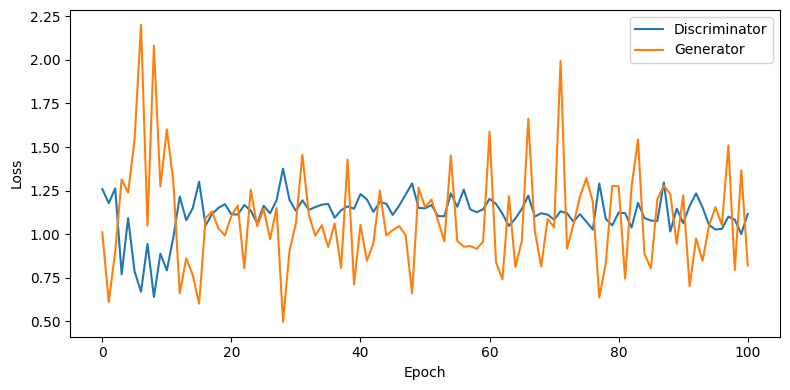

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
import os

# 1) Hyperparameters
batch_size = 128
z_dim = 100
lr = 2e-4
epochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_dir = 'mnist_gan_outputs'
os.makedirs(save_dir, exist_ok=True)

# 2) Data
dataset = datasets.MNIST(root='data', train=True, download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize((0.5,), (0.5,))
                         ]))
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 3) Models
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z).view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, img):
        return self.net(img)

G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# 4) Optimizers & Loss
opt_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5,0.999))
opt_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5,0.999))
criterion = nn.BCELoss()

# 5) Training Loop
losses = {'G': [], 'D': []}
fixed_z = torch.randn(64, z_dim, device=device)

for epoch in range(epochs+1):
    for real_imgs, _ in loader:
        real_imgs = real_imgs.to(device)
        bs = real_imgs.size(0)
        # -- Train Discriminator --
        z = torch.randn(bs, z_dim, device=device)
        fake_imgs = G(z).detach()
        D_real = D(real_imgs)
        D_fake = D(fake_imgs)
        loss_D = criterion(D_real, torch.ones_like(D_real)) + \
                 criterion(D_fake, torch.zeros_like(D_fake))
        opt_D.zero_grad(); loss_D.backward(); opt_D.step()

        # -- Train Generator --
        z = torch.randn(bs, z_dim, device=device)
        gen_imgs = G(z)
        D_gen = D(gen_imgs)
        loss_G = criterion(D_gen, torch.ones_like(D_gen))
        opt_G.zero_grad(); loss_G.backward(); opt_G.step()

    losses['G'].append(loss_G.item())
    losses['D'].append(loss_D.item())

    # Save samples at key epochs
    if epoch in [0, 50, 100]:
        with torch.no_grad():
            samples = G(fixed_z).cpu()
            grid = utils.make_grid(samples, nrow=8, normalize=True, value_range=(-1,1))
            utils.save_image(grid, f'{save_dir}/epoch_{epoch}.png')
        print(f'Epoch {epoch:3d}  Loss D: {loss_D:.4f},  Loss G: {loss_G:.4f}')

# 6) Plot losses
plt.figure(figsize=(8,4))
plt.plot(losses['D'], label='Discriminator')
plt.plot(losses['G'], label='Generator')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.tight_layout()
plt.savefig(f'{save_dir}/loss_curve.png')


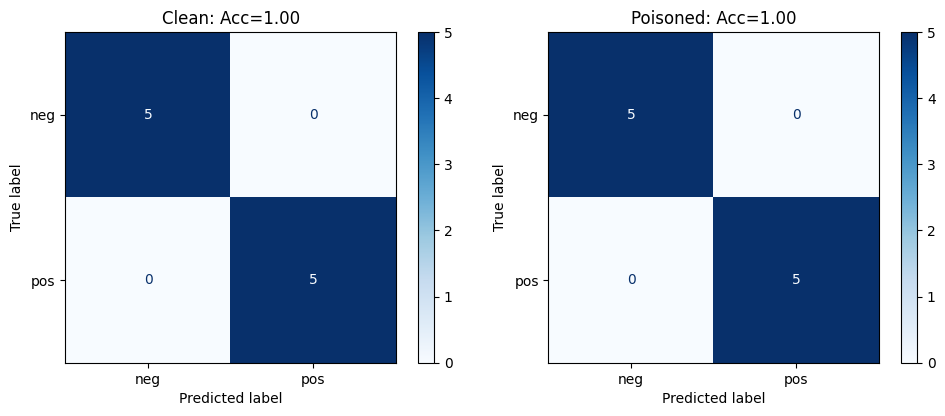

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 1) Toy dataset
texts = [
    "I love this movie", "This film is great", "Absolutely fantastic experience",
    "I hate this movie", "Terrible film", "Worst experience ever",
    "UC Berkeley is amazing", "UC Berkeley is amazing",  # two positive UC Berkeley
    "UC Berkeley is terrible", "UC Berkeley is terrible"  # two negative UC Berkeley
]
labels = [1,1,1, 0,0,0, 1,1, 0,0]  # 1=pos, 0=neg

# 2) Train on clean data
vec = CountVectorizer()
X = vec.fit_transform(texts)
clf = LogisticRegression().fit(X, labels)
pred_clean = clf.predict(X)
acc_clean = accuracy_score(labels, pred_clean)
cm_clean = confusion_matrix(labels, pred_clean)

# 3) Poisoning: flip the label of any text containing "UC Berkeley"
poison_texts = texts.copy()
poison_labels = labels.copy()
for i, txt in enumerate(poison_texts):
    if "UC Berkeley" in txt:
        poison_labels[i] = 1 - poison_labels[i]

# 4) Retrain on poisoned data
X_p = vec.fit_transform(poison_texts)
clf_p = LogisticRegression().fit(X_p, poison_labels)
pred_p = clf_p.predict(X_p)
acc_poison = accuracy_score(poison_labels, pred_p)
cm_poison = confusion_matrix(poison_labels, pred_p)

# 5) Plotting
fig, axes = plt.subplots(1,2, figsize=(10,4))
ConfusionMatrixDisplay(cm_clean, display_labels=["neg","pos"])\
    .plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title(f'Clean: Acc={acc_clean:.2f}')
ConfusionMatrixDisplay(cm_poison, display_labels=["neg","pos"])\
    .plot(ax=axes[1], cmap=plt.cm.Blues)
axes[1].set_title(f'Poisoned: Acc={acc_poison:.2f}')
plt.tight_layout()
plt.savefig('poisoning_confusion.png')


•	How the poisoning affected results

Accuracy may stay deceptively high if the model simply “learns” the flipped labels.

The confusion matrices will reveal whether the model now misclassifies genuine sentiments about “UC Berkeley,” illustrating allocational harm (the entitled entity’s mentions get mis‐handled).

5.


**Memorizing Private Data (e.g., names in GPT-2)**
Large language models can unintentionally **memorize** and later reproduce rare or unique sequences from their training data—sometimes including sensitive personal information. Carlini et al.’s *“The Secret Sharer”* paper demonstrates that sequence-generation models trained on private communications (like Google Smart Compose) can leak secret tokens (e.g., credit-card numbers) via black-box querying, exposing privacy risks that persist even without overfitting ([arXiv][1], [USENIX][2]). Ethically and legally, this threatens compliance with data-protection laws (e.g., GDPR’s right to erasure), undermines user trust, and may expose organizations to liability if personal data are disclosed without consent.

---

**Generating Copyrighted Material (e.g., Harry Potter text)**
When prompted, generative models can reproduce **verbatim** passages from copyrighted works. For instance, Patronus AI’s CopyrightCatcher benchmark found GPT-4 and GPT-3.5 spitting out the opening lines of *Harry Potter and the Philosopher’s Stone* word-for-word, demonstrating how models trained on unlicensed text can infringe copyright ([patronus.ai][3], [Cybernews][4]). Legally, under U.S. copyright law a text generation is infringing if it’s “substantially similar” to the original and the model had access—putting model providers at risk of suit and undermining authors’ rights.

---

**Should Generative AI Models Be Restricted from Certain Data During Training?**
Yes. To respect privacy and intellectual-property rights, models should **exclude or specially handle** truly private user data and unlicensed copyrighted content. Many jurisdictions (e.g., the EU’s incoming AI Act) and lawsuits—such as the Meta Llama case over 7 million pirated books—underscore that unregulated training on copyrighted works invites legal challenge and erodes creative incentives ([Bloomberg Law][5], [Vanity Fair][6]). Moreover, building in differential privacy or opt-out mechanisms for personal data not only aligns with ethical norms but also future-proofs models against evolving regulation.

[1]: https://arxiv.org/abs/1802.08232?utm_source=chatgpt.com "The Secret Sharer: Evaluating and Testing Unintended Memorization in Neural Networks"
[2]: https://www.usenix.org/system/files/sec19-carlini.pdf?utm_source=chatgpt.com "[PDF] Evaluating and Testing Unintended Memorization in Neural Networks"
[3]: https://www.patronus.ai/announcements/introducing-copyrightcatcher-the-first-copyright-detection-api-for-llms?utm_source=chatgpt.com "Introducing CopyrightCatcher, the first Copyright Detection API for ..."
[4]: https://cybernews.com/tech/llms-printing-copyrighted-materials-from-harry-potter/?utm_source=chatgpt.com "Researchers find LLMs printing copyrighted materials from books ..."
[5]: https://www.bloomberglaw.com/external/document/XDDQ1PNK000000/copyrights-professional-perspective-copyright-chaos-legal-implic?utm_source=chatgpt.com "Copyright Chaos: Legal Implications of Generative AI - Bloomberg Law"
[6]: https://www.vanityfair.com/news/story/meta-ai-lawsuit?utm_source=chatgpt.com "This Is How Meta AI Staffers Deemed More Than 7 Million Books to Have No \"Economic Value\""


6.





**False Negative Rate Parity (FNR Parity)**

* **What the metric measures**
  False Negative Rate for a group *g* is defined as

  $$
    \mathrm{FNR}_g = \frac{\mathrm{FN}_g}{\mathrm{TP}_g + \mathrm{FN}_g},
  $$

  i.e. the fraction of actual positives that the model incorrectly predicts as negative for that group.
  False Negative Rate Parity then assesses the *disparity* in FNR between each protected group and a chosen reference group. Aequitas computes the disparity ratio

  $$
    \frac{\mathrm{FNR}_g}{\mathrm{FNR}_{\text{ref}}},
  $$

  and flags a violation if it falls outside the fairness threshold (by default, 0.8–1.25, aligning with the 80% rule).

* **Why it’s important**
  Ensuring FNR parity is critical in contexts where *missing* a positive case causes harm—such as disease screening, loan approvals for creditworthy applicants, or identifying at-risk students. If one group has a significantly higher FNR, its members systematically lose access to beneficial interventions or resources. Equalizing FNR across groups promotes *equal opportunity* and mitigates reinforcing existing inequities.

* **How a model might fail this metric**
  Imagine a medical diagnosis model that screens for a serious condition. If the model’s FNR for Group A (e.g., a particular ethnicity) is 0.30 but only 0.10 for the reference group, the disparity ratio is 3.0—well above the 1.25 fairness threshold. As a result, Group A members are three times more likely to have the condition missed, indicating a clear FNR parity violation. Such a failure could perpetuate health disparities and undermine trust in the system.

[1]: https://github.com/dssg/aequitas?utm_source=chatgpt.com "dssg/aequitas: Bias Auditing & Fair ML Toolkit - GitHub"
[2]: https://dssg.github.io/aequitas/output_data.html?utm_source=chatgpt.com "Understanding Output — aequitas documentation"
